In [12]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Load data from CSV file into a pandas DataFrame
df = pd.read_csv("merged_zeek_logs.csv")

# Convert the DataFrame to a numpy array
labels = df.pop('label') #labels are separated
data_array = df.to_numpy()
print(df.columns)
print(data_array.shape)

Index(['id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'duration',
       'orig_bytes', 'resp_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts',
       'resp_ip_bytes', 'is_icmp', 'http_count', 'ssl_count',
       'avg_seen_bytes_files', 'request_body_len', 'response_body_len',
       'dns_answer_count', 'avg_TTL', 'SLD_freq', 'query_length',
       'service_http', 'service_ssl', 'service_no_service', 'conn_state_RSTO',
       'conn_state_RSTR', 'conn_state_S0', 'conn_state_S1', 'conn_state_S3',
       'conn_state_SF', 'conn_state_SH', 'resumed_T', 'resumed_missing',
       'established_T', 'established_missing',
       'validation_status_not_provided', 'validation_status_missing',
       'method_POST', 'method_no_method', 'status_code_101', 'status_code_200',
       'status_code_204', 'status_code_missing', 'TLD_com', 'TLD_ms',
       'TLD_net', 'TLD_missing'],
      dtype='object')
(234, 47)


## Goal and methods
I think the assignment is fit for semi-supervised outlier detection. I want to see, which data is drastically different from the benign data I know, and then assign them as malicious. This will have lesser accuracy compared to full supervised approach with large dataset. The amount of data is also a problem here, since I have less than 240 points, only about  100 of those are known to be benign. 

For outlier detection, we do have several types of models. Autoencoders, Clustering (namely density-based like DBSCAN), Isolation forrest, Local outlier factor, One-class SVM come to mind. I have experience with clustering, decision/regression trees (pointing at the isolation forrest) and SVMs, so I am more likely to use these. I will analyze different models alter to select one or two.

#### Metrics for comparing models
I have to design the goal metric in a away I can measure. There are not as many metrics useful for this task, since it is not fully supervised and I dont have a proper test set/validation data (I cannot use full accuracy, F1 measure and alike). I want to ensure, that (almost) all of the actually benign data are correctly classified as benign. This leads me to Recall on benign data, which i want to maximize. Recall is how many of the known benign is classified as benign (inlier in my case) by the model. 

Here we have amounts of labels given beforehand. All flows which started less than 4 minutes after the beginning of the capture are assumed benign, others are unknown for now.
- label
- unknown    132
- benign     102

In the end, we will call all the known benign data benign, but now we are trying to assert if the unknown samples are possibly also benign or malicious. 

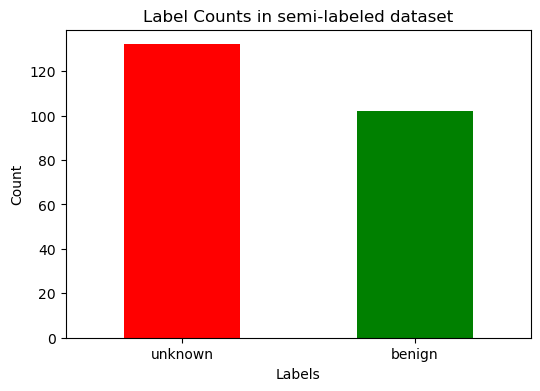

In [29]:
label_counts = labels.value_counts()

label_counts.plot(kind="bar", color=["red", "green"], figsize=(6, 4))
plt.title("Label Counts in semi-labeled dataset")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

## Feature selection, normalisation and dimensionality reduction

I will be using mostly sk-learn classes unless necessary to use something else, because I am familiar with the API and sk-learn offers all of the functionality I need for this.
I want to experiment with different data normalisation, feature selection, visualisation methods, dimensionality reduction and methods of outlier detection. 

Why outlier detection (OD)? I think it is the only useful ML paradigm for this task, because I have not been given all labeled data. I only have "benign" data, and only some of it. Hence, I want to recognize, that data "similar" to benign data is probably benign, and outliers/ radically different data MIGHT be malicious. I think, that in real systems, only a very small amount of traffic is malicious, but we really need to find it. Therefore, I will label everything not similar to my labeled benign as malicious. My system will have a large error, but I want to minimize False-Negative error on class of malicious data, which means capturing a lot of malicious data, but probably taking a lot of benign data with it.

#### Scaling

First before anything, we need to scale the data properly, so we can use other ML techniques.
I have 2 techniques in mind: Zero-mean and min-max normalisation. I would not use min-max here because I think there might be some outliers int he dataset, which could "throw off" scaling of some of the features. I think the dataset is very small and both methods would perform fine here, but zero mean normalisation is my more favourite one. :))

We will try using visualisation technique t-SNE (similar to U-map), which is a non linear-technique (as opposed to PCA for example).


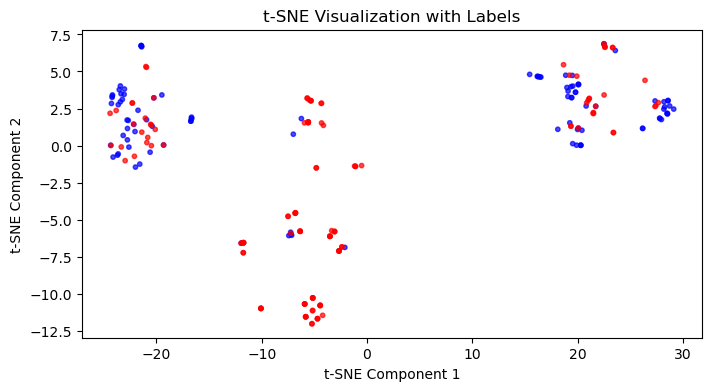

In [14]:
# zero-mean normalization
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_array)

tsne = TSNE(n_components=2, random_state=11111)
tsne_results = tsne.fit_transform(normalized_data)

# Map labels to colors
label_colors = labels.map({'benign': 'blue', 'unknown': 'red'})

# Plot the t-SNE results with colors based on labels
plt.figure(figsize=(8, 4))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=label_colors, s=10, alpha=0.7)
plt.title("t-SNE Visualization with Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

Blue points were labeled by me as benign based on provided information. this does not mean the red are all malicious, only that they might be. My thinking is, points close to many benign points are probably also benign?

#### Feature selection

I have 48 columns, but I assume some might have very similar contents (high corellation/colinearity/similarity). We can measure corellation of the columns or use my favourite technique, clustering!
Clustering the columns (features) might reveal similar features, which dont provide enough information. Agglomerative clustering can be used for this.

We do have 48 columns initially. We want smaller number, but if we "compress" the columns too much, then we lose a lot of important variation in the data.
This is also a part of the solution to the curse of dimensionality. We have very few data, hence we want to reduce the number of dimensions to prevent overfitting. Feature selection and dimensionality reduction are a good way to approach this. I'd like to have about 10x as many data as features, leading to about 20-25 features? This also depends on outlier detection technique used.


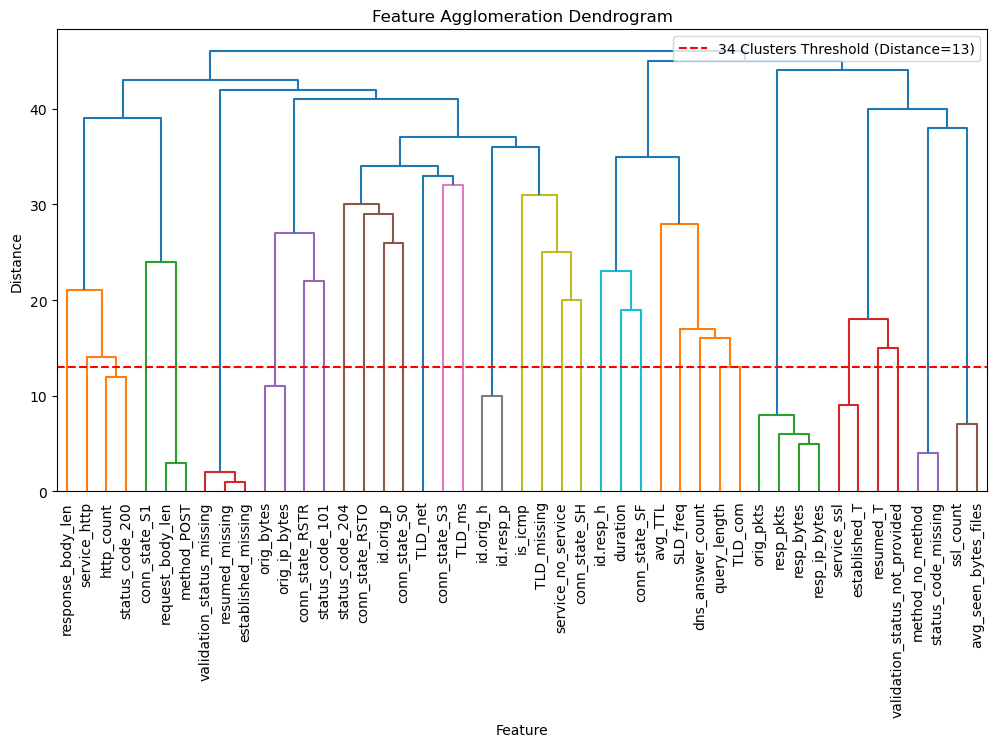

Number of clusters joined below the line: 12


In [15]:
n_clusters =  34
f_agg = cluster.FeatureAgglomeration(
    n_clusters=n_clusters, linkage="ward"
)  # ward, complete, average, single
features_selected_data = f_agg.fit_transform(normalized_data)

n_features = normalized_data.shape[1]  
distances = np.arange(1, f_agg.children_.shape[0] + 1) 
linkage_matrix = np.column_stack(
    [
        f_agg.children_,  # Merging order
        distances,  # Estimated distances
        np.ones(f_agg.children_.shape[0]),  # Cluster sizes (not used but required)
    ]
).astype(float)


# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=df.columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Feature Agglomeration Dendrogram")
plt.xlabel("Feature")
plt.ylabel("Distance")

# Plot the line for 40 clusters
threshold = distances[-n_clusters]  # Distance at which 40 clusters are formed
plt.axhline(
    y=threshold,
    color="r",
    linestyle="--",
    label=f"{n_clusters} Clusters Threshold (Distance={threshold})",
)

# Count how many clusters were joined below the line
joined_below_line = np.sum(distances < threshold)
plt.legend()
plt.show()

print(f"Number of clusters joined below the line: {joined_below_line}")

Dendrogram shows the order of "joining" of the clusets of features. closer to the bottom, the more similar they were.
We can see, that we have joined some of the features (below the line) and we can see which. This was calculated based on ward linkage (commonly used type of linkage between clusters)
On the vertical line, we can see the ward "distances" between pairs of clusters based on where they meet. Ward linkage is the criterion, which minimizes the variance of clusters being merged. 

We can see, that the closest features are established_missing and returned_missing, meaning those are very often together. There is a similarity between request body length and if the method for http request is POST. Both are 0 if the request is not http request at all. There are more similarities, which can be seen in the dendrogram at the bottom.

It is not clear which type of linkage to choose. I would not choose single linkage, this usually results in a sort of chaining (single linkage joint clusters which have the closest value inbetween some of their data). I used ward, since it is the standard, but average or complete would be good too. Complete is very computation heavy, but we have a small amount of data.

I have selected the amount of clusters by hand. We want less features, but not to distort the data too much. for example I think having http service and code 200 is very much connected, since almost all flows with http connection had code 200. Thats why I decided to merge the last two. This class merged the features in the end by averaging the features in the cluster.

#### Dimensionality Reduction

kolik chci dimenzí? třeba 25-30? cca 1/10 např. záleží na modelech :))
we aim for around 95% of explained variance ratio (less than that, we are starting to really compress the data and lose a lot of information)

Explained variance by each component: [1.82049036e-01 1.40918026e-01 1.05661756e-01 8.93096170e-02
 5.18411217e-02 4.71687697e-02 4.38243994e-02 4.25970290e-02
 3.27891661e-02 2.50562120e-02 2.37537080e-02 2.30176618e-02
 2.23692963e-02 2.18835776e-02 2.12793295e-02 1.99508252e-02
 1.76360982e-02 1.63327812e-02 1.36503753e-02 1.16652455e-02
 8.58644185e-03 8.34423828e-03 7.60579937e-03 6.58544748e-03
 4.72627034e-03 2.92260898e-03 1.91949807e-03 1.46781927e-03
 1.42428584e-03 1.27059678e-03 9.00922565e-04 7.71922533e-04
 2.27005610e-04 1.62049221e-04 1.53662670e-04 9.31928662e-05
 7.70063609e-05 3.59058971e-06 2.68646928e-06 9.23487256e-07
 3.59028419e-32 1.31552634e-33 1.03254432e-33 1.03254432e-33
 1.03254432e-33 1.03254432e-33 1.03254432e-33]
Total explained variance: 0.9999999999999998
Total explained variance cumulative: [0.18204904 0.32296706 0.42862882 0.51793843 0.56977956 0.61694833
 0.66077273 0.70336975 0.73615892 0.76121513 0.78496884 0.8079865
 0.8303558  0.85223938 0.8735

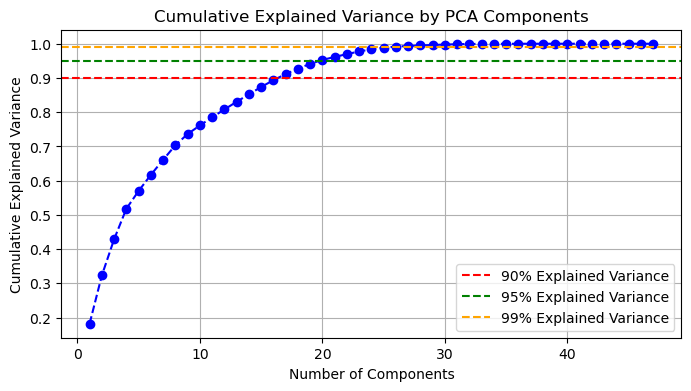

In [19]:
n_components = features_selected_data.shape[1]
pca = PCA(n_components=n_components)
pca.fit(features_selected_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance}")
print(f"Total explained variance: {explained_variance.sum()}")
print(f"Total explained variance cumulative: {explained_variance.cumsum()}")

# Plot the cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(
    np.arange(1, n_components + 1),
    explained_variance.cumsum(),
    marker="o",
    linestyle="--",
    color="b",
)

plt.axhline(y=0.9, color="r", linestyle="--", label="90% Explained Variance")
plt.axhline(y=0.95, color="g", linestyle="--", label="95% Explained Variance")
plt.axhline(y=0.99, color="orange", linestyle="--", label="99% Explained Variance")

plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid()
plt.show()

What dimension do we want? we want around 20-25 dimensions, because it is sufficiently low and we retain as much data as possible. We can use explained variance to guide us. In the plot above, we can see if we retain 25 features from the dimensions with the largest variance, we "retain" around 95% od variance. This means abour 5% error? 25 dimensions only have around 1% error. 

We can use an "elbow" rule, we can see between 20 and 25 (approximately), the increase of information levels out and each dimension only helps us very slightly.

`Lets say we want 20 dimensions, so we have a good convergence in the outlier detection algorithms, but dont loose too much information.`

In [22]:
n_components = 20
pca = PCA(n_components=n_components)
pca_data = pca.fit(features_selected_data)

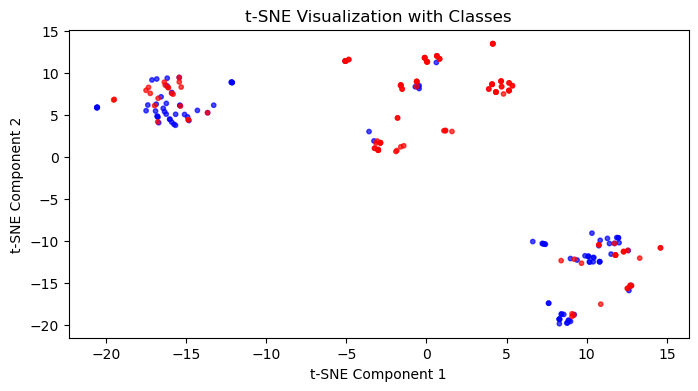

In [25]:
# Plot the t-SNE results with colors based on labels
tsne_results = tsne.fit_transform(pca_data.transform(features_selected_data))
plt.figure(figsize=(8, 4))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=label_colors, s=10, alpha=0.7)
plt.title("t-SNE Visualization with Classes")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

We can see, that the approximate groups int he data havent changed much in comparison to t-SNE visualisation at the beginning. This was what I assumed was gaing to happen. We didnt make any major changes to the data, just merged some similar features and then removed a small amount of information via PCA (but remnoved many dimensions). t-SNE is non-linear meaning it maps the data onto some kind of non-linear "bent" space (to put it very bluntly). The positions of the groups has changed, but the relative proximity of neighboring points did not really change much when converting from 20 to 2 dimensions. 

## Outlier detection
Finally, we can get to finding the outliers!
We know one thing which unsupervised outlier detection does not know. for some of the data, we have the benign label. Most methods, like Local Outlier Factor take the data as all the same and can classify even known benign data as outliers, because they are so different from others in the dataset. I want to use knowledge of some labels to separate more probable outliers. 

#### Idea 1: Clustering 
I think I can use clustering for my use-case, since I can use the knowledge of known benign data to classify clusters. Density based clustering is an option, since it by default can detect outliers as not being in any cluster. I have found few examples with other clustering methods or novel clustering algorithms made ofr this use.

`https://www.sciencedirect.com/science/article/pii/S0378475410000510?casa_token=FC78TBrDRHUAAAAA:bK-R44T17g-e6q1V8sCaKoEHr-xqN56lNtzNOTFdX0UfS2VY9cG6byDc24Y7VawLNCjf_6EVMA`
`https://dl.acm.org/doi/pdf/10.1145/1141277.1141421`

I will be using density-based algorithm DBSCAN for reason explained above. I first cluster the data, then set a threshold. If a cluster has more % of benign data than the threshold, then I claim it is benign (and all data inside). 

#### Idea 2: One-Class SVM on the benign data
One-class svm but on the known benign data could do the trick? Usually one-class SVM does not handle outliers well (as do most SVMs), but if I train the classifier on only known benign data, other benign data should be also classified correctly? (inside the decision boundary)
Data which is not inside the decision boundary will be presented as outliers. This approach has a problem, we effectively only use around 100 data points for training, since we dont have more with a label. Usually we would use all points regardless of a label, but I feel we would not use the available information this way.

#### Idea 3: Isolation forrest and tuning a threshold
Isolation forrest provides anomaly score for each point (lower score, higher abnormality in sk-learn). We can tune some threshold to then "pick out" only certain amount of the most probable outliers. If we can approximate the amount of traffic being malicious, we would think the most probable outliers should be this malicious traffic. If we say 95% of the traffic is benign, we can then set the threshold for outlier coefficient and label only 5% of the traffic as anomalies based on this. Disadvantage: we have to approximate amount of benign traffic. if we didnt know there was something benign in the dataset, we could set it to 99% ar 99.9% purity. Some attacks, which start many connections would also break this approach (as well as many other outlier detection methods).


#### *I will be trying the Idea 1 and the Idea 2*


### Parameter tuning and validation metrics

So what does the metric look like exactly, how do i calculate it and how do I interpret this metric?

In [ ]:
# TODO: definice té metriky? ještě nějaká další??
# ROC? fce na výpočet?

How do I do parameter tuning?